# VFI, Stochastic Problems and the Meaning of All of This

In the last session, we took a look at deterministic problems.
Here, we look at stochastic problems.

We take the Neoclassical Growth Model with stochastic capital productivity as an example.
The problem is the following:

\begin{align*}
    V(k, a) &= \max_{c, k'} \dfrac{c^{1-\gamma}}{1-\gamma} + \beta \cdot \mathbf{E} \left( V \left( k', a' \right) \right) \\
            &\qquad \text{s.t.}
                \begin{cases}
                    c + k' \leq \exp(a) \cdot k^\alpha + (1-\delta) k \\
                    a' = (1-\rho) \mu + \rho a + \varepsilon' \\
                    \varepsilon' \overset{iid}{\sim} \mathcal{N} (0, \sigma^2)\\
                    c \geq 0
                \end{cases}
\end{align*}

The numerical complication with this model is that $a$ takes on a continuum of values.
When we use VFI, we need to discretize the grid for the state space, which in this case is $(k, a)$.
While discretizing the grid for capital is relatively straightforward, discretizing a stochastic (exogenous) variable is less obvious.
Obtaining values on the grid for $a$ is not the problem.
The problem is discretizing the randomness associated to it.

This session is organized in three parts.
First, we look at how we can discretize AR(1) processes, which are ubiquitous in Macro models.
Second, we use VFI to solve the problem above.
Finally, we get to see what we can use numerical solutions for.

In [1]:
import numpy as np
from scipy import linalg as la
from scipy import stats as st
from matplotlib import pyplot as plt
from time import time

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

## Discretizing AR(1) processes

The theory of how to do that is discussed in class with the Professor.
Here we quickly review the methods and we look at some code that implements them.
The methods we look at are three:
- [Tauchen (1986)](https://www.sciencedirect.com/science/article/pii/0165176586901680)
- [Tauchen and Hussey (1991)](https://doi.org/10.2307/2938261)
- Rouwenhorst, revamped by [Kopecky and Suen (2010)](https://doi.org/10.1016/j.red.2010.02.002)

The goal of this methods is common.
For a given AR(1) model, we want to construct a discrete Markov chain process such that it matches the moments of the original AR(1) specification.
This allows us to consider a sequence of discrete random variables in place of a sequence of continuous random variables.
We want to do so because we numerically discretize the state variables of the Bellman equations, including stochastic ones.

Before we move on, note that the process for $a$, conditional on the AR(1) specification, is entirely characterized by $\mu$, $\rho$ and $\sigma$.

### Tauchen (1986)

This method is a classic.
It is easy to code and easy to understand.

In [2]:
def tauchen(n, m, mu, rho, sigma):
    sMax = m * sigma
    S, step = np.linspace(-sMax, sMax, num=n, retstep=True)
    x = S - rho * S.reshape((-1, 1)) + step/2
    Pi = st.norm.cdf(x / sigma)
    Pi[:, -1] = 1.
    Pi[:, 1:] = np.diff(Pi)
    S += mu  # centering around unconditional mean
    return S, Pi

A few comments on this code.
We conveniently defined a function to implement the method.
We need to know the following:
- `n` the number of grid points we want to have;
- `m` how far apart from the unconditional mean we want to go;
- `mu`, the unconditional mean of the AR(1) process ($\mu$);
- `rho`, the persistence of the AR(1) process ($\rho$); and
- `sigma`, the standard deviation of the innovations.

We start the procedure by assuming that the process has zero mean.
We cherry-pick a value `sMax` that will be the maximum value on the grid.
Given that the grid is centered around zero (for now), `-sMax` will be the minimum value.

We then create the grid for the values of the random variable `S`, and we make sure we know the distance between one point and the next one, `step`.

The matrix `x` is the ancestor of the transition matrix `Pi`, and it consists of the support of the normal random variable that governs transitions in the AR(1) specification.
Because we are computing transition probabilities, the matrix `x` represents all possible transitions.

`Pi` is defined by computing the Gaussian CDF at the gridpoints `x`, normalized by the dispersion `sigma`.
Its last column is filled with ones and then we take first differences across columns (by default, [`np.diff`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html) operates along the last dimension--axis--of an array).
This effectively implements what you have on the slides distributed by Marco.

Finally, we re-center the grid `S` around the unconditional average of the process `mu`.

### Tauchen and Hussey (1991)

This is an improvement upon Tauchen (1986).
What it does is essentially the same as Tauchen, except that it leverages nodes in a Gauss-Hermite polynomial.

In [3]:
def tauchussey(n, mu, rho, sigma):
    S, step = np.polynomial.hermite.hermgauss(n)
    S += np.sqrt(2) * sigma
    pdf = ( st.norm.pdf(S, rho * S.reshape((-1,1)), sigma) /
            st.norm.pdf(S, 0, sigma) )
    Pi = step / np.sqrt(np.pi) * pdf
    Pi /= Pi.sum(axis=1, keepdims=True)
    S += mu
    return S, Pi

Note that, relative to Tauchen (1986), here we do not specify the parameter `m`.
This means that this method does not allow us any control over the grid we want to obtain.

The rest is very similar to Tauchen's method.
The steps are organized the exact same way and the intuition is the same.
The improvement lies in using nodes of Gauss-Hermite polynomials (both in determining the grid and in computing probabilities).
This is a bit more sophisticated than using linearly spaced points for the grid and allows for a better match of the AR(1) moments we're targeting.

To see how Gauss-Hermite nodes stack against linearly spaced points, take a look at [this dedicated notebook](../code_examples/hermgauss_vs_linspace.ipynb).

### Rouwenhorst (see Kopecky and Suen, 2010)

The Rouwenhorst method was already known, but was not very popular.
Kopecky and Suen (2010) bring back the method to the attention of economists.

The way it works is different than the other methods above.
Here is the code.

In [4]:
def rouwenhorst(n, mu, rho, sigma):
    def compute_P(p, n):
        if n == 2:
            P = np.array([[p, 1-p], [1-p, p]], dtype=float)
        else:
            Q = compute_P(p, n-1)
            A = np.zeros((n, n))
            B = np.zeros((n, n))
            A[:n-1, :n-1] += Q
            A[1:n, 1:n] += Q
            B[:n-1, 1:n] += Q
            B[1:n, :n-1] += Q
            P = p * A + (1-p) * B
            P[1:-1, :] /= 2
        return P
    p = (1 + rho) / 2
    Pi = compute_P(p, n)
    f = np.sqrt(n-1) * (sigma / np.sqrt(1 - rho**2))
    S = np.linspace(-f, f, n) + mu
    return S, Pi

The way this works is easily visualized in Marco's slides.
In a nutshell, the method starts by a 2-by-2 symmetric transition matrix.
Symmetry here implies homoskedasticity of the error terms of the "upstream" AR(1) process.
It then scales up the transition matrix to a `n`-by-`n` one by compounding successive iterations of the 2-by-2 case, carefully allocating values across the matrices `A` and `B`.

Note that, similarly to the Tauchen and Hussey (1991) algorithm, the end user (us) have no manual control over the grid.
This ensures that the grid points are properly chosen according to the (unconditional) support of the AR(1) process.

Rouwenhorst's method is significantly more robust to highly persistent AR(1) processes relative to the methods above.
This means that we can use this method is suitable for $|\rho| > 0.9$ (this is just an eye-balled value).

### Ergodic distribution of a discrete Markov chain

For nice Markov chains, it is useful to define the ergodic distribution of the states.
This gives the long-run distribution of the exogenous variable we are trying to model.
In case of stationary processes, this coincides with the unconditional probability distribution of the states.

One way to compute ergodic distribution is to observe the following.
Given a (right-stochastic) transition matrix $\Pi$, the ergodic distribution $\pi$ is characterized as

\begin{align*}
    \begin{cases}
        \Pi' \pi = \pi \\
        \pi \cdot \iota = 1,
    \end{cases}
\end{align*}

where $\iota$ is a vector of ones that is conformable to $\pi$ for the inner product.

This looks like an eigenvalue-eigenvector problem.
The ergodic distribution $\pi$ is the eigenvector of $\Pi$ associated with the unit eigenvalue.
However, eigenvectors and eigenvalues are unique only up to scale.
This gives a role to the second equation in the system above, which gives us a way to choose the right scale we need.

Hence, this routine follows.

In [5]:
def ergodic_distribution(Pi):
    l, v = la.eig(Pi)
    vector = v[:, np.where(np.isclose(l, 1.))]
    return (vector / np.sum(vector)).reshape((-1,))

## VFI and solution to the stochastic neo-classical growth model

Now that we have these methods, we can solve the problem above.
This is not much different from the model in the previous TA session.
All we do is adding a new state variable, which represents capital's productivity.

Similarly to last time, we proceed in the following way:
1. We calibrate the model;
1. We create discrete grids for the state variables;
1. We set a criterion for assessing convergence of the algorithm;
1. We use VFI to solve the model; and
1. We check the results graphically.

We calibrate the model with the same parameters as the deterministic version of the model.
However, we need to add values to characterize the exogenous process we introduced here.

In [6]:
alpha = 0.3
beta = 0.95
delta = 0.1
gamma = 1.5
u = lambda c : c**(1-gamma) / (1-gamma)

mu = 0
rho = 0.8
sigma = 0.1

Now we create the discrete grids for the state variables.
The grid for capital is obtained in the same way as last time.

In [7]:
Nk = 1000

k_dss = ((1 - (1-delta) * beta) / (alpha * beta)) ** (1 / (alpha-1))
k_lo, k_hi = np.array([0.1, 2.5]) * k_dss

K = np.linspace(k_lo, k_hi, num=Nk)

The grid for capital productivity will be given by the procedure we use to discretize the AR(1) process.
As we chose a relatively persistent process for productivity shocks, we are going to use Rouwenhorst's method.

In [8]:
Na = 2

A, P = rouwenhorst(Na, mu, rho, sigma)
A = np.exp(A)

In [9]:
print('    Low productivity: exp(a) = {:.3f}\n'.format(A[0]) + 
      '   High productivity: exp(a) = {:.3f}\n'.format(A[-1]) +
      'Average productivity: exp(a) = {:.3f}'.format(np.exp(mu + sigma**2/2)))

    Low productivity: exp(a) = 0.846
   High productivity: exp(a) = 1.181
Average productivity: exp(a) = 1.005


Note that the average productivity is not unity.
Because productivity is [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution), the average is $\exp(\mu + \sigma^2/2)$.

We now proceed to preallocating the arrays that will store the results, setting the criterion to assess convergence.

In [10]:
U = np.zeros((Nk, Na))
V0 = np.zeros((Nk, Na))
V1 = np.zeros((Nk, Na))
DRk = np.zeros((Nk, Na), dtype=int)

criterion = 1.
tolerance = 1e-6
n_iter = 0

We finally run VFI.

In [11]:
t0 = time()

while criterion > tolerance:
    n_iter += 1
    for i in range(Nk):
        for j in range(Na):
            C = A[j] * K[i]**alpha + (1 - delta) * K[i] - K
            C[C < 0] = np.nan
            U[:, j] = u(C)
        objective = U + beta * V0 @ P.T
        V1[i, :] = np.nanmax(objective, axis=0)
        DRk[i, :] = np.nanargmax(objective, axis=0)
    criterion = np.max(np.max(np.abs(V1 - V0)))
    V0[:] = V1
    
t1 = time()

K1 = K[DRk]
C = np.zeros((Nk, Na))
for j in range(Na):
    C[:, j] = A[j] * K**alpha + (1 - delta) * K - K1[:, j]

k_ss = K1[np.where(np.isclose(K.reshape((-1, 1)), K1))][np.array([2, -3])]

print('Algorithm took {:.3f} seconds with {} iterations'.format((t1-t0),
                                                                n_iter))

Algorithm took 46.123 seconds with 285 iterations


A few notes on what is going on here.

First, note that the value `k_dss` that we computed above is the _deterministic_ steady state of capital.
This means that `k_dss` is the steady state if all exogenous variables were deterministically set to their unconditional averages.
Here, `k_ss` is the _vector_ of steady state capital holdings _conditional_ on productivity.
In practice, this is computed by looking up where `K` and `K1` are closest to each other, with the small catch that no values of `K1` are identical to `K`.

Second, we have two `for` loops in VFI.
This happens because we need to construct counterfactual proposals for $V(k,a)$ for every value the state space might be.
More in general, we will nest as many `for` loops as state variables.
There are ways to get around this (e.g., vectorizing matrices), but researchers always try to squeeze state variables as much as possible (e.g., the _cash-in-hand_ trick in the Huggett and Aiyagari models we will see in later TA sessions).

Third, we could be using PFI or direct projection also here.
PFI in particular is suitable here because it dramatically reduces the amount of time required to converge to a solution.
Direct projection is feasible, but I do not show it here because we saw it is not much reliable.

We now turn to plotting the results.

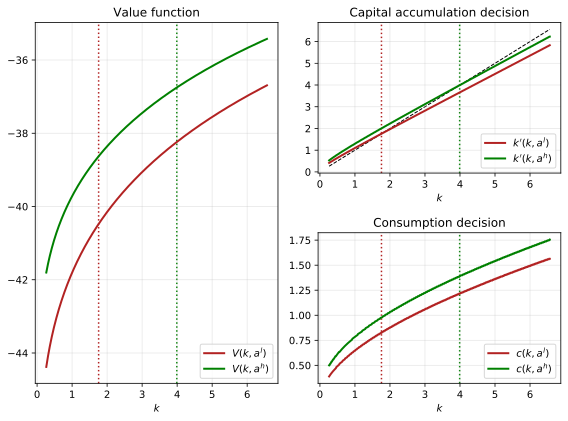

In [12]:
colorstate = ['firebrick', 'green']
V_labels = [r'$V(k, a^l)$', r'$V(k, a^h)$']
C_labels = [r'$c(k, a^l)$', r'$c(k, a^h)$']
K_labels = [r"$k'(k, a^l)$", r"$k'(k, a^h)$"]

fig = plt.subplots(figsize=(8, 6))
ax = [None] * 3

pltgrid = (2, 2)
ax[0] = plt.subplot2grid(pltgrid, (0, 0), rowspan=2)
ax[1] = plt.subplot2grid(pltgrid, (0, 1))
ax[2] = plt.subplot2grid(pltgrid, (1, 1))

for a in range(Na):
    ax[0].plot(K, V1[:, a],
               linewidth=2,
               color=colorstate[a],
               label=V_labels[a])
    ax[1].plot(K, K1[:, a],
               linewidth=2,
               color=colorstate[a],
               label=K_labels[a],
               zorder=2)
    ax[2].plot(K, C[:, a],
               linewidth=2,
               color=colorstate[a],
               label=C_labels[a])
ax[1].plot(K, K,
           linewidth=1,
           color='black',
           linestyle='dashed',
           zorder=1)

ax[0].set_title('Value function')
ax[1].set_title('Capital accumulation decision')
ax[2].set_title('Consumption decision')

for a in range(3):
    ax[a].axvline(k_ss[0],
                  color=colorstate[0],
                  linestyle='dotted',
                  zorder=1)
    ax[a].axvline(k_ss[1],
                  color=colorstate[1],
                  linestyle='dotted',
                  zorder=1)
    ax[a].grid(alpha=0.3)
    ax[a].set_xlabel('$k$')
    ax[a].legend()

plt.tight_layout()

Here, we plotted the value function $V(k,a)$ _conditional_ on $a$ assuming the value $a^l$ or $a^h$.
We also observe that the conditional capital accumulation rules intersect the 45° line at two different values, which are the conditional steady states.
The deterministic steady state lies in between, as it assumes that the exogenous variable always equals its unconditional average.

In [13]:
print('          Low steady state: k = {:.3f}\n'.format(k_ss[0]) +
      '         High steady state: k = {:.3f}\n'.format(k_ss[1]) + 
      'Deterministic steady state: k = {:.3f}'.format(k_dss))

          Low steady state: k = 1.758
         High steady state: k = 3.991
Deterministic steady state: k = 2.626


## Simulating the model

By now we should be asking the question: why are we doing this?
The main reason for which we numerically solve models is that we want to use analytically intractable equations to make predictions.
Whether we have a normative or a positive model, we want to be able to verify certain properties of the (endogenous) variables in the model.

So far, we obtained policy functions.
These alone are not very informative.
Moreover, as we typically reverse-engineer models to obtain certain results, we should have a pretty solid idea of what the policy functions look like.
To further explore properties of the model, we need to simulate the model.
This means repeatedly applying the solution of the model (which typically consists of policy functions + given laws of motion + given exogenous processes) to an initial condition.

To gain further understanding, observe that a rational expectations model is described by the following system of equations:

\begin{align*}
    \mathbf{E}_t \big( F(X_{t-1}, X_t, X_{t+1}) \big) = 0,
\end{align*}

where $X_t$ is the vector of all endogenous and exogenous variables of the model, and the associated solution looks like

\begin{align*}
    X_{t+1} = G(X_{t-1}, X_t).
\end{align*}

The (vector) function $G(\cdot)$, together with an initial condition $X_0$, induces a sequence ${(X_t)}_{t=0}^{\infty}$ that we call _simulation_.
In a baseline DSGE model, as we have representative-agents economies, the simulation is the time series of the vector of variables of the model.
These time series will feature statistical moments, such as unconditional (historical) averages, conditional averages, cross-correlations and auto-correlations.
We typically want to compare these moments against those we observe in the data to assess a model.

In what follows, we simulate the model we solved above.
What we have here is not a state-of-the-art exercise.
In particular, we are dealing with a two-points grid for productivity, and hence we draw from these two values only (we can improve on this, keeping a two-points grid for $a$: how?).

We proceed in the following way.
For every period $t$:
1. We enter period $t$ with given capital holdings $k_t$;
1. We draw a realization of $a_t$;
1. We use the policy function $c(k_t)$ to obtain $c_t$;
1. We use the policy function $k'(k_t)$ to obtain $k_{t+1}$;
1. We use definitions in the model to compute output $y_t$ and investment $i_t$; and
1. We move on to period $t+1$ with the state $k_{t+1}$.

The code does this heavily relying on indices: we are drawing `i in range(Na)` instead of `a in A`.
We also use the policy functions by using indices.

First, let us define useful functions for drawing integers from a known (discrete) distribution function.

In [14]:
def draw_state(pdf):
    cdf = np.cumsum(pdf)
    u = np.random.uniform()
    state_index = np.sum(u - cdf > 0)
    return int(state_index)

Second, we define a function that finds the closest possible element to `value` in a given `array`.

In [15]:
def find_nearest(array, value, give_idx=False):
    if array.ndim != 1:
        raise ValueError('Input vector must be uni-dimensional')
    idx = (np.abs(array - value)).argmin()
    if give_idx:
        return idx
    else:
        return array[idx]

Then, we define how long we want our simulation to be, and we preallocate the arrays where we store the results.

In [16]:
T = 250

a = np.zeros((T,), dtype=int)
k = np.zeros((T,), dtype=int)

We now proceed to choose initial conditions for the simulations.
This is completely arbitrary a choice.
Given that the policy function $G(\cdot)$ naturally defines autocorrelated endogenous variables, the choice of the initial condition is non-trivial.
In particular, every realization we draw from the model will depend on them, however marginally.

There are two good candidates here.
One way is to pick steady state values.
This ensures that the initial condition does not look too farfetched relative to the rest of the simulation.
The second way is to simulate the model for many more periods than `T` and to just consider the last `T` "observations."
This should intuitively remove any (numerical) correlation with the initial condition.

Here, we pick the steady state values.

In [17]:
a[0] = draw_state(ergodic_distribution(P))  # drawing an index for grid A
k[0] = find_nearest(K, k_dss, give_idx=True)    # getting index for K

Because the stochastic NeoClassical Growth Model is "small," we just need to simulate productivity and capital holdings at every iteration of the `for` loop that follows.
The other endogenous variables we look at here (i.e., consumption, production and investment) are all deterministic functions of $(k_t, a_t)$.
This is because $k_t$ and $a_t$ are the state variables of the problem.

In [18]:
for t in range(T-1):
    a[t+1] = draw_state(P[a[t], :])  # drawing an index for grid A
    k[t+1] = DRk[k[t], a[t]]         # drawing an index for grid K

capital = K[k]
shocks = A[a]

Now, we are left with computing the other interesting variables of the model.

In [19]:
production = np.zeros((T,))
investment = np.zeros((T,))
consumption = np.zeros((T,))

for t in range(T-1):
    production[t] = shocks[t] * capital[t] ** alpha
    investment[t] = capital[t+1] - (1 - delta) * capital[t]
    consumption[t] = production[t] - investment[t]

Note that we did not compute certain values.
Particularly, investment in the last period, $i_T$, has not been computed because it relies on the value $k_{T+1}$, which we did not simulate above.
Similarly, we cannot have consumption in the last period, $c_T$.
For these two reasons, we prematurely stopped the iteration of the simulation (i.e., the last value in `range(T-1)` is `T-2`, which is the second to last admissible position in an array with `T` elements).
Consequently, we did not compute production in the last period, $y_T$.

In [20]:
production[-1] = shocks[-1] * capital[-1] ** alpha
investment[-1] = np.nan
consumption[-1] = np.nan

For every of these variables, we can compute the corresponding _conditional_ steady states.

In [21]:
y_ss = A * k_ss ** alpha
i_ss = delta * k_ss  # k_ss - (1 - delta) * k_ss
c_ss = y_ss - i_ss

We are now ready to plot the simulations.
We do so by shading low-productivity times in gray, in a similar ways to what [FRED does in their figures with NBER recessions](https://fred.stlouisfed.org/series/GDPC1).

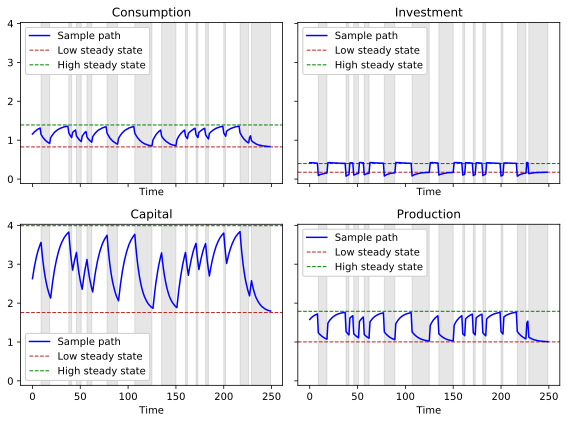

In [22]:
lows = shocks < 1
low_in = [i for i in range(1, T) if (lows[i-1] == False and lows[i] == True)]
low_out = [i for i in range(T-1) if (lows[i] == True and lows[i+1] == False)]
if lows[0] == True:
    low_in.insert(0, 0)
if lows[T-1] == True:
    low_out.append(T-1)

prop_sims = {'color':     'blue',
             'linewidth': 1.5,
             'zorder':    3,
             'label':     'Sample path'}

prop_ss_lo = {'color':     colorstate[0],
              'linewidth': 1,
              'linestyle': 'dashed',
              'zorder':    2,
              'label':     'Low steady state'}

prop_ss_hi = {'color':     colorstate[1],
              'linewidth': 1,
              'linestyle': 'dashed',
              'zorder':    2,
              'label':     'High steady state'}

fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 6))

ax1[0, 0].plot(consumption, **prop_sims)
ax1[0, 1].plot(investment,  **prop_sims)
ax1[1, 0].plot(capital,     **prop_sims)
ax1[1, 1].plot(production,  **prop_sims)

ax1[0, 0].axhline(c_ss[0], **prop_ss_lo)
ax1[0, 0].axhline(c_ss[1], **prop_ss_hi)
ax1[0, 1].axhline(i_ss[0], **prop_ss_lo)
ax1[0, 1].axhline(i_ss[1], **prop_ss_hi)
ax1[1, 0].axhline(k_ss[0], **prop_ss_lo)
ax1[1, 0].axhline(k_ss[1], **prop_ss_hi)
ax1[1, 1].axhline(y_ss[0], **prop_ss_lo)
ax1[1, 1].axhline(y_ss[1], **prop_ss_hi)

for i in range(2):
    for j in range(2):
        ax1[i, j].set_xlabel('Time')
        ax1[i, j].legend(framealpha=1)
        for a, b in zip(low_in, low_out):
            ax1[i, j].axvspan(a, b, color='black', alpha=0.1, zorder=1)

ax1[0, 0].set_title('Consumption')
ax1[0, 1].set_title('Investment')
ax1[1, 0].set_title('Capital')
ax1[1, 1].set_title('Production')

plt.tight_layout()

A few remarks are due.

As soon as a "good" period starts (i.e., the beginning of each non-shaded area), the agent realizes to be in a high productivity regime.
This makes her react consistently with the policy functions $c(k, a^h)$ and $k'(k, a^h)$.
If a given regime lasts long enough, every variable converges to the respective conditional steady state.
The only way to deviate from such convergence is to receive a regime-switching shock.

Although the policy functions incorporate averaged future payoffs (i.e., are obtained by optimizing $\mathbf{E} \left( V \left( k',a' \right) \right)$), the simulations never converge to average values.
If we had multiple productivity values, we would have multiple levels at which the simulations may converge.

Moreover, these simulations are not very realistic.
We draw only two possible values of productivity in order to stay on the grid on which we solved the model.
By increasing the number of values in the grid for the state space, we can obtain more compelling paths for the endogenous variables.

Finally, given the sample realizations for `consumption`, `investment`, `capital` and `production`, we can compute numerical statistics to compare against real-world moments.
For example, we can compute historical averages, historical volatilities, cross-correlations and auto-correlations.
This exercise, however, critically depends on the calibration of the model, especially when it comes to the unit of measurements and the frequency at which the model is simulated.
In this particular case, having output roughly between 1 and 2 is not particularly meaningful.
However, we can interpret the other variables _relative to_ output in terms of their magnitude.